In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = '../'

## Response Variable

Before we can build our model, we need to load in the frog occurrences data and generate our response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [2]:
#if not os.path.exists(data_path+'training_data/'):
 #   os.mkdir(data_path+'training_data/')
  #  with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
   #     zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv('occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Sub-sampling

For this demonstration, we will constrain our search to frogs in the Greater Sydney area found between the start of 2015 to the end of 2019. This gives a varied landscape of bushland, plains, rivers, and urban areas. This is done by providing `year_range` and `bbox` parameters to the get_frogs function we defined above.

In [3]:
# Define the bounding box for Test Region 5

min_lon5, min_lat5 = (115.7, -32.5)  # Lower-left corner
max_lon5, max_lat5 = (116.7, -31.5)  # Upper-right corner
bbox5 = (min_lon5, min_lat5, max_lon5, max_lat5)

# Load in data
#all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
boxes = [bbox5]
#all_frog_data = get_frogs('occurrence.txt', year_range=(2015, 2019), bbox=bbox)
#all_frog_data[('species'=='Litoria Fallax')]

#get_frogs('occurrence.txt', year_range=(2015, 2019), bbox=i

## Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. For a more in-depth look at the TerraClimate dataset and how to query it, see the [TerraClimate supplementary notebook](./supplementary_notebooks/TerraClimate.ipynb)

### Accessing the TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take four metrics from four assets, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 512).


In [4]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

Reference evapotranspiration (ASCE Penman-Montieth), Runoff, Actual Evapotranspiration, Climate Water Deficit, Soil Moisture, Snow Water Equivalent, Palmer Drought Severity Index, Vapor pressure deficit


In [5]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2020-12-31')

# Measurements to take: primary + secondary variables
assets=['tmax', 'tmin', 'ppt', 'srad','vap','aet','pet']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean','srad_mean','vap_mean','aet_mean','pet_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

#weather_data = get_terraclimate(bbox5, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
weather_data = xr.open_dataset('weather_data_testRegion5.nc')
display(weather_data.band.values)

array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'srad_mean', 'vap_mean',
       'aet_mean', 'pet_mean'], dtype=object)

In [6]:
# These stuff combines the lat& longs of the test region, and the weather_data, into a dictionary
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_regions = [{'title': 4, 'bbox': (115.7, -32.5, 116.7, -31.5)}]
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = weather_data
    #get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    #region['result'] = predict_frogs(region['predictors'], clf2) > 0.5
    #region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    #plt.show()

In [10]:
region.keys()

dict_keys(['title', 'bbox', 'coords', 'predictors'])

In [14]:
region_coords = region['coords']

In [15]:
# Since there is no 'key' in weather data (as in frog_data), we need to manually assign
region_coords = (region_coords.reset_index(drop=True).assign(key=lambda x: x.index))

In [16]:
region_coords

,id,decimalLongitude,decimalLatitude,key
0,3453,115.886000,-31.936300,0
1,3454,115.887000,-31.936500,1
2,3455,115.885000,-31.938400,2
3,3456,115.883000,-31.940300,3
4,3457,115.858000,-32.046300,4
...,...,...,...,...
593,4046,116.150192,-31.884385,593
594,4047,115.779737,-32.412962,594
595,4048,115.856628,-32.147959,595
596,4049,116.238000,-31.827000,596


In [21]:
# Try to use the joining funtion to join climates and region coords
def join_frogs(coords, data):
    """Collects the weather data for each frog location and joins it onto the test coordinates
    Arguments:
    coords -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return coords.merge(
        (data#.rename('data')
            .sel(
                x=xr.DataArray(coords.decimalLongitude, dims="key", coords={"key": coords.key}), 
                y=xr.DataArray(coords.decimalLatitude, dims="key", coords={"key": coords.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
region5 = join_frogs(region_coords, weather_data)
region5.head()

,id,decimalLongitude,decimalLatitude,key,aet_mean,pet_mean,ppt_mean,srad_mean,tmax_mean,tmin_mean,vap_mean
0,3453,115.886,-31.9363,0,47.099998,140.916672,51.400002,234.066666,24.546669,13.283335,1.3445
1,3454,115.887,-31.9365,1,47.099998,140.916672,51.400002,234.066666,24.546669,13.283335,1.3445
2,3455,115.885,-31.9384,2,47.099998,140.916672,51.400002,234.066666,24.546669,13.283335,1.3445
3,3456,115.883,-31.9403,3,47.099998,140.916672,51.400002,234.066666,24.546669,13.283335,1.3445
4,3457,115.858,-32.0463,4,48.700001,139.833328,53.833332,233.683334,24.253334,13.290004,1.3510


In [23]:
region5.to_csv('testRegion5.csv')

In [24]:
region5.describe()

,id,decimalLongitude,decimalLatitude,key,aet_mean,pet_mean,ppt_mean,srad_mean,tmax_mean,tmin_mean,vap_mean
count,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000
mean,3751.500000,115.947188,-31.938912,298.500000,47.160259,138.985641,54.854843,233.986572,24.294550,12.665580,1.306463
std,172.772008,0.105253,0.159036,172.772008,2.485145,3.513252,6.707797,0.879288,0.514562,0.838230,0.063692
min,3453.000000,115.716004,-32.412962,0.000000,34.833332,127.283333,42.416668,230.883331,22.576670,10.203335,1.138667
25%,3602.250000,115.886611,-32.032353,149.250000,45.966667,139.187500,51.033333,233.783340,24.136667,12.428335,1.305833
50%,3751.500000,115.916289,-31.932650,298.500000,47.099998,139.833328,51.400002,234.066666,24.546669,13.060001,1.332167
75%,3900.750000,115.995500,-31.864550,447.750000,48.483334,140.916672,55.566666,234.633331,24.601667,13.283335,1.344500
max,4050.000000,116.377369,-31.551600,597.000000,53.683334,142.766663,79.666664,235.850006,24.856668,13.560000,1.387000


### Predict frogs function

Loading data
Calculating mean
Calculating min
Calculating max


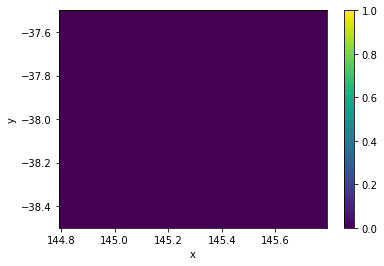

Loading data
Calculating mean
Calculating min
Calculating max


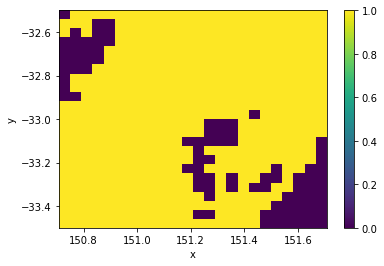

Loading data
Calculating mean
Calculating min
Calculating max


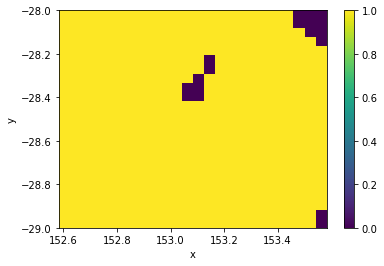

Loading data
Calculating mean
Calculating min
Calculating max


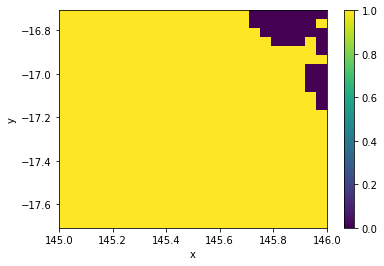

Loading data
Calculating mean
Calculating min
Calculating max


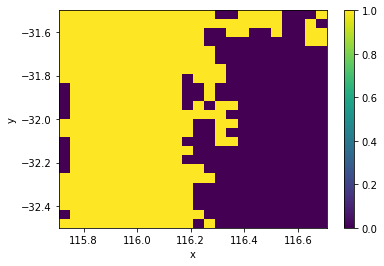

In [15]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], bestForest4) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()
    

What we are left with is a submission file with three columns: decimalLatitude, decimalLongitude, and occurrenceStatus. This is the file you will submit to the EY Data Science Challenge platform to receive your score on the leaderboard.

In [21]:
display(submission)

# Save to output folder
submission.to_csv('challenge_1_submission_Forest4.csv', index=None)

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,0
1,1,-37.770833,144.979167,0
2,2,-37.979167,145.354167,0
3,3,-37.604167,145.020833,0
4,4,-38.479167,145.645833,0
...,...,...,...,...
4046,4046,-31.895833,116.145833,1
4047,4047,-32.395833,115.770833,1
4048,4048,-32.145833,115.854167,1
4049,4049,-31.812500,116.229167,1


In [18]:
submission.groupby('occurrenceStatus').count()

,id,decimalLatitude,decimalLongitude
occurrenceStatus,,,
0,1658,1658,1658
1,2393,2393,2393


In [19]:
submission[(submission['decimalLongitude'] < 116.7) & (submission['decimalLongitude'] > 115.7)].groupby('occurrenceStatus').count()

,id,decimalLatitude,decimalLongitude
occurrenceStatus,,,
0,10,10,10
1,588,588,588


### Get Frogging!

Now that you have witnessed a basic approach to model training, its time to try your own approach! Feel free to modify any of the functions presented in this notebook. A good start might be to try running this notebook on a region different to Greater Sydney, or even on multiple regions.

Be sure to address some of the assumptions made here, particularly ways to address the sampling bias in the dataset. Our pseudo-absence method was just one idea, you may want to persue another. Another important issue to consider is that of class imbalance. In this notebook, we simply down-sampled the non-target species to match the number of target species. This may not be ideal, as an isolated frog occurrence may be lost while clusters of occurrences are more likely to persist. Perhaps a method of sampling only from clustered occurrences would address class imbalance while also helping to offset the sampling bias. Just a thought! You might even decide on a completely different training set, such as classifying regions rather than points. Do whatever you think will create the best model for predicting the frog habitat of the species of interest. Happy frogging!

### Check what the output should look like - test submission csv

In [76]:
test = pd.read_csv('test submission.csv')
test

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,0
1,1,-37.770833,144.979167,0
2,2,-37.979167,145.354167,0
3,3,-37.604167,145.020833,0
4,4,-38.479167,145.645833,0
...,...,...,...,...
4046,4046,-31.895833,116.145833,0
4047,4047,-32.395833,115.770833,0
4048,4048,-32.145833,115.854167,0
4049,4049,-31.812500,116.229167,0


In [77]:
test.groupby('occurrenceStatus').count()

,id,decimalLatitude,decimalLongitude
occurrenceStatus,,,
0,2116,2116,2116
1,1935,1935,1935
